# Validation of Wind & Wave data from Satellite Altimetry & Buoys observations

## Purpose

In this Notebook, we test how consistent are the wind and significant wave height data from SARAL-AltiKa & Jason 3 satellites with observations from the NDBC buoys moored in the domain.

## Methodology

1. The first step is to keep only the valid significant wave height satellite observations on the grounds that there are many outliers owing to land contamination and the sensitivity of altimeters to rain. The criteria are included and described in the references. We keep the satellite wind speed data correspondingly. The wind speed data from the buoys must be converted in 10 meters height using the boundary layer law.
2. Now we have the valid satellite data that we will use. The second step is to create histograms of wave data and maps of the wind and wave data in the domain of interest.
3. Create a co-location algorithm. First we detect and keep satellite observations in specific distance from each buoy's location. The domain of interest is located close to the coast, therefore the distance of 10km is chosen. For every observation in the specific distance limit, we compute the time difference between each satellite observation and each buoy observation. We keep only the observations with a time difference of 15 minutes.
4. Plot the collocated observations and perform statistical analysis.

## Work in Progress - improvements

1. Statistical relationship of wind and wave data.
2. Investigation of the consistency of the aforementioned relationship with theoretical bulk formulae.

## Results

# Setup

## Library Import

First we import all the required Python libraries.

In [1]:
#data manipulation
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#double iteration in pandas
from itertools import product

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)
import hvplot.pandas

pd.options.plotting.backend = 'holoviews'

## Data Import

We import all the required data from the local folders

## SARAL-AltiKa Data

We use the Level 2 IGDR data from the drifting phase (2016-)

In [2]:
#load all the netcdf files and merge them in one dataset
ds1 = xr.open_mfdataset('C:/Users/panmits86/Desktop/SA_val/SRL_IPN_2PTP*.nc')
#select all the required variables to detect only the valid data
ds2 = ds1[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
#convert to pandas dataframe
ds3 = ds2.to_dataframe()
ds3.reset_index(inplace=True)
ds3

<ipython-input-2-5079ff3981e4>:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds1 = xr.open_mfdataset('C:/Users/panmits86/Desktop/SA_val/SRL_IPN_2PTP*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


,time,swh,swh_rms,surface_type,wind_speed_alt,ice_flag,sig0,off_nadir_angle_wf,sig0_rms,range_rms,swh_numval,lat,lon
0,2016-07-05 23:28:55.833936960,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,41.939267,286.087682
1,2016-07-05 23:28:56.871984000,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,41.878463,286.066813
2,2016-07-05 23:28:57.910032960,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,41.817656,286.045974
3,2016-07-05 23:28:58.948080064,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,41.756846,286.025167
4,2016-07-05 23:28:59.986126912,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,41.696032,286.004391
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,2019-12-27 23:18:57.428019968,2.356,1.030,0.0,7.38,0.0,10.86,0.1191,0.19,0.1196,38.0,40.282097,286.566410
13139,2019-12-27 23:18:58.466595200,2.168,0.994,0.0,8.17,0.0,10.53,0.1227,0.07,0.0823,39.0,40.221190,286.546347
13140,2019-12-27 23:18:59.504633856,2.860,1.725,0.0,8.01,0.0,10.59,0.1223,0.06,0.0942,40.0,40.160311,286.526321
13141,2019-12-27 23:19:00.542678784,2.756,1.431,0.0,8.27,0.0,10.49,0.1223,0.08,0.1265,39.0,40.099430,286.506324


In [7]:
#keep only the valid data using the filtering criteria described in the references
wh_sa = ds3[(ds3['surface_type'] == 0.) & (ds3['ice_flag'] == 0.) & (ds3['swh'] < 30.) & (ds3['sig0'] <= 30.) & (ds3['sig0'] >= 3.) \
            & (ds3['off_nadir_angle_wf'] <= 0.0625) & (ds3['off_nadir_angle_wf'] >= -0.2) & (ds3['wind_speed_alt'] <= 30) & \
             (ds3['sig0_rms'] <= 1) & (ds3['range_rms'] <= 0.2) & (ds3['swh_numval'] >= 20) & (ds3['swh_rms'] < 30.)]
wh_sa

,time,swh,swh_rms,surface_type,wind_speed_alt,ice_flag,sig0,off_nadir_angle_wf,sig0_rms,range_rms,swh_numval,lat,lon
5,2016-07-07 10:14:46.507452032,1.438,1.210,0.0,1.37,0.0,19.109999,0.0169,0.22,0.0740,23.0,40.009084,289.708927
8,2016-07-07 10:14:49.624763008,1.013,0.441,0.0,1.13,0.0,22.109999,0.0015,0.36,0.0551,23.0,40.191881,289.648891
10,2016-07-07 10:14:51.702971008,1.557,1.396,0.0,1.21,0.0,20.850000,-0.0070,0.37,0.1013,27.0,40.313731,289.608727
11,2016-07-07 10:14:52.742073088,1.090,0.519,0.0,1.35,0.0,19.359999,0.0110,0.29,0.0607,38.0,40.374652,289.588603
12,2016-07-07 10:14:53.781178944,0.786,0.369,0.0,1.17,0.0,21.410000,0.0004,0.61,0.0443,34.0,40.435571,289.568450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13069,2019-12-22 10:22:46.047041920,0.576,0.380,0.0,4.69,0.0,12.130000,0.0026,0.08,0.0243,40.0,40.025461,286.145365
13070,2019-12-22 10:22:47.084560896,0.296,0.285,0.0,4.74,0.0,12.099999,0.0023,0.07,0.0274,38.0,40.086325,286.125404
13071,2019-12-22 10:22:48.122082176,0.407,0.318,0.0,4.58,0.0,12.200000,0.0022,0.07,0.0261,39.0,40.147186,286.105414
13072,2019-12-22 10:22:49.159601152,0.489,0.305,0.0,4.26,0.0,12.420000,0.0031,0.11,0.0273,40.0,40.208044,286.085398


In [8]:
swh_sa = wh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa = swh_sa[['time','lat','lon','swh','wind_speed_alt']]
swh_sa

,time,lat,lon,swh,wind_speed_alt
0,2016-07-07 10:14:46.507452032,40.009084,289.708927,1.438,1.37
1,2016-07-07 10:14:49.624763008,40.191881,289.648891,1.013,1.13
2,2016-07-07 10:14:51.702971008,40.313731,289.608727,1.557,1.21
3,2016-07-07 10:14:52.742073088,40.374652,289.588603,1.090,1.35
4,2016-07-07 10:14:53.781178944,40.435571,289.568450,0.786,1.17
...,...,...,...,...,...
6391,2019-12-22 10:22:46.047041920,40.025461,286.145365,0.576,4.69
6392,2019-12-22 10:22:47.084560896,40.086325,286.125404,0.296,4.74
6393,2019-12-22 10:22:48.122082176,40.147186,286.105414,0.407,4.58
6394,2019-12-22 10:22:49.159601152,40.208044,286.085398,0.489,4.26


## Jason 3 Data

We use the Level 2 IGDR data (2016-)

In [10]:
#load all the netcdf files and merge them in one dataset
ds4 = xr.open_mfdataset('C:/Users/panmits86/Desktop/J3_val/JA3_IPN_2P*.nc')
#select all the required variables to detect only the valid data
ds5 = ds4[['swh_ku','swh_rms_ku','surface_type','wind_speed_alt','ice_flag','sig0_ku','off_nadir_angle_wf_ku','sig0_rms_ku','range_rms_ku', \
           'swh_numval_ku', 'swh_rms_ku']]
#convert to pandas dataframe
ds6 = ds5.to_dataframe()
ds6.reset_index(inplace=True)
ds6

<ipython-input-10-4e7a641fad81>:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds4 = xr.open_mfdataset('C:/Users/panmits86/Desktop/J3_val/JA3_IPN_2P*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


,time,swh_ku,swh_rms_ku,surface_type,wind_speed_alt,ice_flag,sig0_ku,off_nadir_angle_wf_ku,sig0_rms_ku,range_rms_ku,swh_numval_ku,lon,lat
0,2016-02-12 09:50:32.680412992,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.542018,41.958367
1,2016-02-12 09:50:33.699121984,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.577454,41.912746
2,2016-02-12 09:50:34.717833024,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.612834,41.867111
3,2016-02-12 09:50:35.736542016,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.648157,41.821462
4,2016-02-12 09:50:36.755253056,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,288.683425,41.775800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,2019-12-31 08:20:26.514081024,3.691,0.470,0.0,11.05,0.0,12.450000,-0.0139,0.50,0.1101,20.0,289.833967,40.236319
21116,2019-12-31 08:20:27.532790144,4.026,0.475,0.0,10.21,0.0,12.639999,0.0106,0.48,0.0873,20.0,289.867387,40.190195
21117,2019-12-31 08:20:28.551498880,3.902,0.526,0.0,11.25,0.0,12.380000,-0.0121,0.31,0.0775,20.0,289.900756,40.144058
21118,2019-12-31 08:20:29.570209920,4.183,0.622,0.0,11.54,0.0,12.290000,-0.0196,0.40,0.1153,20.0,289.934074,40.097909


In [11]:
#keep only the valid data using the filtering criteria described in the references
wh_ja = ds6[(ds6['surface_type'] == 0.) & (ds6['ice_flag'] == 0.) & (ds6['swh_ku'] < 30.) & (ds6['sig0_ku'] <= 32.38) & \
            (ds6['sig0_ku'] >= 9.38)\
            & (ds6['off_nadir_angle_wf_ku'] <= 0.64) & (ds6['off_nadir_angle_wf_ku'] >= -0.2) & (ds6['wind_speed_alt'] <= 30) & \
             (ds6['sig0_rms_ku'] <= 2.5) & (ds6['range_rms_ku'] <= 0.0115*ds6['swh_ku'] + 0.2) & (ds6['swh_numval_ku'] >= 10) & \
            (ds6['swh_rms_ku'] < ds6['swh_ku'])]
wh_ja

,time,swh_ku,swh_rms_ku,surface_type,wind_speed_alt,ice_flag,sig0_ku,off_nadir_angle_wf_ku,sig0_rms_ku,range_rms_ku,swh_numval_ku,lon,lat
12,2016-02-12 09:50:44.904932032,1.586,0.476,0.0,6.480000,0.0,13.710000,0.1059,0.79,0.0686,20.0,288.963563,41.409998
13,2016-02-12 09:50:45.923640960,1.738,0.421,0.0,10.400000,0.0,12.580000,0.0385,0.33,0.0732,20.0,288.998332,41.364211
14,2016-02-12 09:50:46.942352064,1.924,0.426,0.0,10.620000,0.0,12.500000,0.0486,0.43,0.0831,20.0,289.033047,41.318410
15,2016-02-12 09:50:47.961060992,1.782,0.531,0.0,12.030000,0.0,12.120000,0.0231,0.28,0.0836,20.0,289.067708,41.272596
16,2016-02-12 09:50:48.979772096,2.203,0.587,0.0,12.849999,0.0,11.870000,0.0026,0.38,0.0792,20.0,289.102314,41.226768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,2019-12-31 08:20:26.514081024,3.691,0.470,0.0,11.050000,0.0,12.450000,-0.0139,0.50,0.1101,20.0,289.833967,40.236319
21116,2019-12-31 08:20:27.532790144,4.026,0.475,0.0,10.210000,0.0,12.639999,0.0106,0.48,0.0873,20.0,289.867387,40.190195
21117,2019-12-31 08:20:28.551498880,3.902,0.526,0.0,11.250000,0.0,12.380000,-0.0121,0.31,0.0775,20.0,289.900756,40.144058
21118,2019-12-31 08:20:29.570209920,4.183,0.622,0.0,11.540000,0.0,12.290000,-0.0196,0.40,0.1153,20.0,289.934074,40.097909


In [13]:
swh_ja = wh_ja.reset_index()
swh_ja.drop(['index'], axis=1, inplace=True)
swh_ja = swh_ja[['time','lat','lon','swh_ku','wind_speed_alt']]
swh_ja

,time,lat,lon,swh_ku,wind_speed_alt
0,2016-02-12 09:50:44.904932032,41.409998,288.963563,1.586,6.480000
1,2016-02-12 09:50:45.923640960,41.364211,288.998332,1.738,10.400000
2,2016-02-12 09:50:46.942352064,41.318410,289.033047,1.924,10.620000
3,2016-02-12 09:50:47.961060992,41.272596,289.067708,1.782,12.030000
4,2016-02-12 09:50:48.979772096,41.226768,289.102314,2.203,12.849999
...,...,...,...,...,...
9701,2019-12-31 08:20:26.514081024,40.236319,289.833967,3.691,11.050000
9702,2019-12-31 08:20:27.532790144,40.190195,289.867387,4.026,10.210000
9703,2019-12-31 08:20:28.551498880,40.144058,289.900756,3.902,11.250000
9704,2019-12-31 08:20:29.570209920,40.097909,289.934074,4.183,11.540000


## Buoys

In [14]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [15]:
# data for buoy 44097
b44097 = (buoys['Latitude'][0],buoys['Longitude'][0]+360)
b44097

(40.969, 288.873)

In [16]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [17]:
#read all files for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44097'
all_files = glob.glob(path + "/*.txt")

b44097_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,8,9], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44097_wave = b44097_wave[b44097_wave.WVHT !=99]
b44097_wave.reset_index(inplace=True)
b44097_wave.drop('index', 1, inplace=True)
b44097_wave

,Date,WVHT,DPD
0,2009-10-21 23:31:00,0.59,8.33
1,2009-10-22 00:01:00,0.65,8.33
2,2009-10-22 00:31:00,0.57,8.33
3,2009-10-22 01:01:00,0.55,5.88
4,2009-10-22 01:31:00,0.57,7.69
...,...,...,...
150672,2019-12-31 21:30:00,2.03,9.09
150673,2019-12-31 22:00:00,1.75,9.88
150674,2019-12-31 22:30:00,1.83,9.09
150675,2019-12-31 23:00:00,1.99,9.09


In [18]:
b_time = b44097_wave['Date']
b_time

0        2009-10-21 23:31:00
1        2009-10-22 00:01:00
2        2009-10-22 00:31:00
3        2009-10-22 01:01:00
4        2009-10-22 01:31:00
                 ...        
150672   2019-12-31 21:30:00
150673   2019-12-31 22:00:00
150674   2019-12-31 22:30:00
150675   2019-12-31 23:00:00
150676   2019-12-31 23:30:00
Name: Date, Length: 150677, dtype: datetime64[ns]

## Data Processing

### SARAL-AltiKa Wave Height histogram

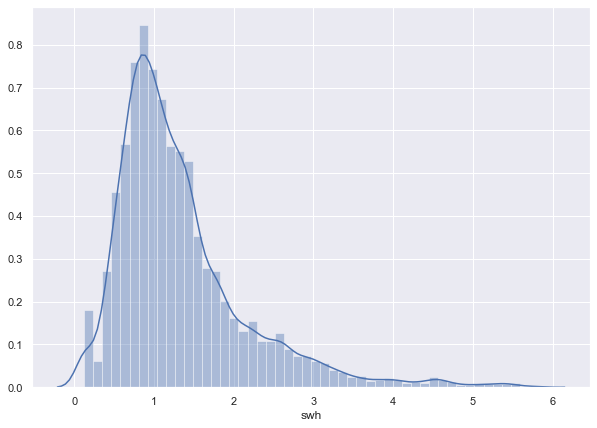

In [9]:
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(swh_sa['swh'])

In [ ]:
# SARAL-AltiKa Wave Height histogram
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(swh_ja['swh_ku'])

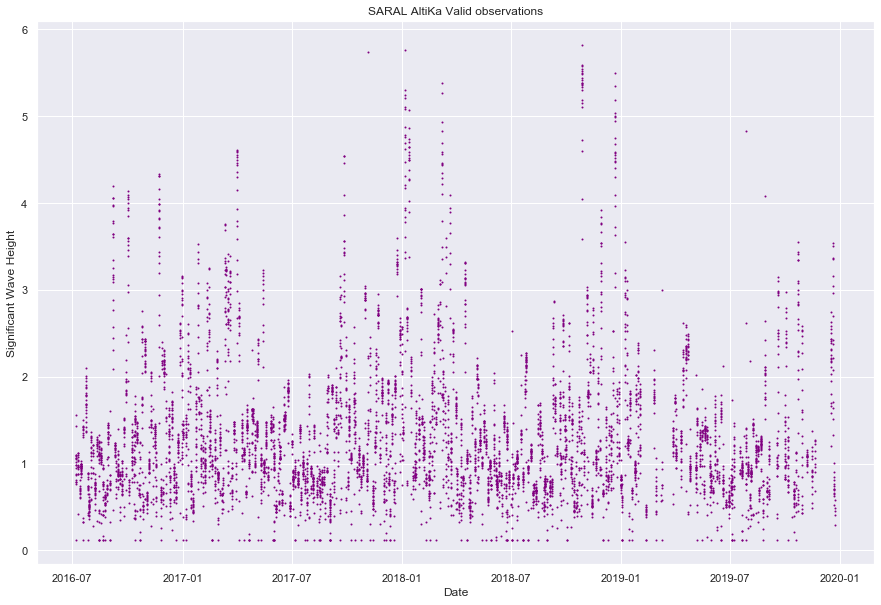

In [70]:
# SARAL-AltiKa valid observations time series
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(swh_sa['time'],swh_sa['swh'],s=1,color='purple')
ax.set(xlabel="Date",
       ylabel="Significant Wave Height",
       title="SARAL AltiKa Valid observations")

plt.savefig('saral_altika_wh.png', dpi=300)

### Map of SARAL-AltiKa Valid Observations

In [67]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

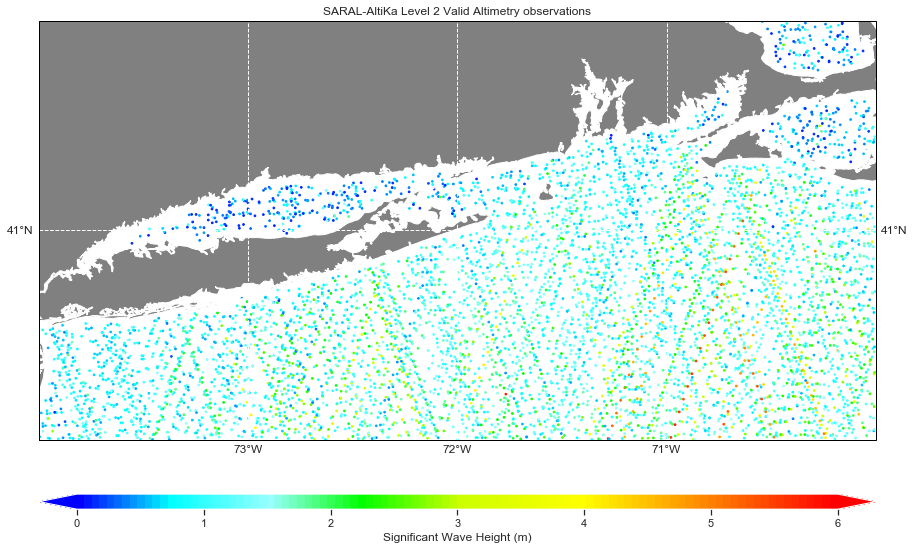

In [92]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations for the 1st quarter of 2018.
#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['swh'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('SARAL-AltiKa Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_SA_valid.png', dpi=300, bbox_inches='tight')

### Map of Jason 3 valid observations

In [19]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

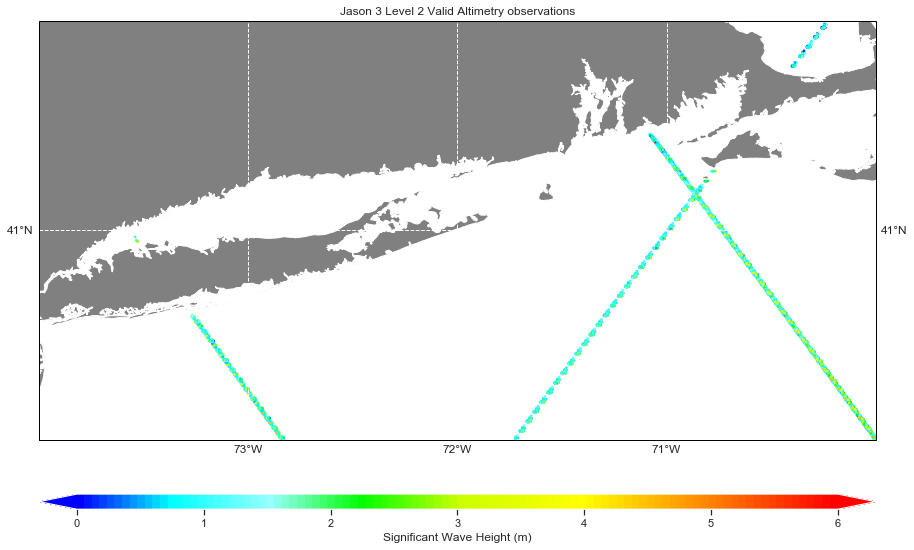

In [22]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations for the 1st quarter of 2018.
#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_ja['lon'], swh_ja['lat'], c=swh_ja['swh_ku'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('Jason 3 Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_JA3_valid.png', dpi=300, bbox_inches='tight')

## Co-location Algorithm

### SARAL-AltiKa

In [24]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [25]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav5 = haversine_vector([b44097]*swh_sa.shape[0],a1, Unit.KILOMETERS)
# b5 not usable
#b5 = np.where(hav5<10)
#b5

In [26]:
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,128.023195
1,108.445160
2,95.720222
3,89.497867
4,83.396777
...,...
6391,253.366240
6392,252.096991
6393,251.014717
6394,250.121589


In [32]:
dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = dist['Buoy-Sat. Distance (km)'] < 10.
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh,wind_speed_alt
0,2016-07-23 10:16:35.685429120,40.968513,288.982312,1.613,6.910000
1,2016-11-14 23:16:05.754334912,41.024070,288.884184,1.336,8.210000
2,2016-11-14 23:16:06.791853888,40.963248,288.863787,1.323,8.320000
3,2016-11-14 23:16:07.829375040,40.902423,288.843419,1.421,8.679999
4,2016-12-08 10:16:19.682451008,40.905110,288.896660,1.283,5.380000
5,2016-12-08 10:16:20.720496896,40.965961,288.876277,1.197,5.120000
6,2016-12-08 10:16:21.758544896,41.026810,288.855864,1.134,4.730000
7,2017-01-30 23:16:02.151683072,41.020870,288.787378,1.033,10.030000
8,2017-01-30 23:16:03.191314944,40.959947,288.766947,1.045,9.740000
9,2017-02-23 10:16:07.018265984,40.899859,288.840185,0.919,2.300000


In [28]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)

In [38]:
#time difference in minutes
diff = [(b_time[d], b44097_wave['WVHT'][d], sat_time['time'][s], colocated['swh'][s], (sat_time['time'][s] - b_time[d]).total_seconds() / 60)\
        for d, s in product(range(b_time.shape[0]), range(sat_time.shape[0]))]

In [39]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', 'Time Difference']
t

,Buoy 44097 Time,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,Time Difference
0,2009-10-21 23:31:00,0.59,2016-07-23 10:16:35.685429120,1.613,3.551686e+06
1,2009-10-21 23:31:00,0.59,2016-11-14 23:16:05.754334912,1.336,3.716625e+06
2,2009-10-21 23:31:00,0.59,2016-11-14 23:16:06.791853888,1.323,3.716625e+06
3,2009-10-21 23:31:00,0.59,2016-11-14 23:16:07.829375040,1.421,3.716625e+06
4,2009-10-21 23:31:00,0.59,2016-12-08 10:16:19.682451008,1.283,3.750405e+06
...,...,...,...,...,...
7081814,2019-12-31 23:30:00,1.93,2019-04-18 23:11:10.289199872,2.326,-3.700988e+05
7081815,2019-12-31 23:30:00,1.93,2019-05-04 23:11:41.286758912,0.832,-3.470583e+05
7081816,2019-12-31 23:30:00,1.93,2019-05-04 23:11:42.325335040,0.931,-3.470583e+05
7081817,2019-12-31 23:30:00,1.93,2019-05-04 23:11:43.363912064,0.966,-3.470583e+05


In [42]:
final = abs(t['Time Difference']) < 15.
final1 = t[final]
final1

,Buoy 44097 Time,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,Time Difference
4577565,2016-07-23 10:25:00,1.52,2016-07-23 10:16:35.685429120,1.613,-8.405243
4801568,2016-11-14 23:25:00,1.34,2016-11-14 23:16:05.754334912,1.336,-8.904094
4801569,2016-11-14 23:25:00,1.34,2016-11-14 23:16:06.791853888,1.323,-8.886802
4801570,2016-11-14 23:25:00,1.34,2016-11-14 23:16:07.829375040,1.421,-8.869510
4853929,2016-12-08 10:25:00,1.21,2016-12-08 10:16:19.682451008,1.283,-8.671959
4853930,2016-12-08 10:25:00,1.21,2016-12-08 10:16:20.720496896,1.197,-8.654658
4853931,2016-12-08 10:25:00,1.21,2016-12-08 10:16:21.758544896,1.134,-8.637358
4973876,2017-01-30 23:25:00,0.95,2017-01-30 23:16:02.151683072,1.033,-8.964139
4973877,2017-01-30 23:25:00,0.95,2017-01-30 23:16:03.191314944,1.045,-8.946811
5025484,2017-02-23 10:25:00,0.92,2017-02-23 10:16:07.018265984,0.919,-8.883029


In [43]:
df1 = final1.iloc[:,[1,3]]
df1.reset_index(inplace=True)
df1.drop('index', 1, inplace=True)
df1

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Buoy 44097 Wave Height,SARAL-AltiKa Wave Height
0,1.52,1.613
1,1.34,1.336
2,1.34,1.323
3,1.34,1.421
4,1.21,1.283
5,1.21,1.197
6,1.21,1.134
7,0.95,1.033
8,0.95,1.045
9,0.92,0.919


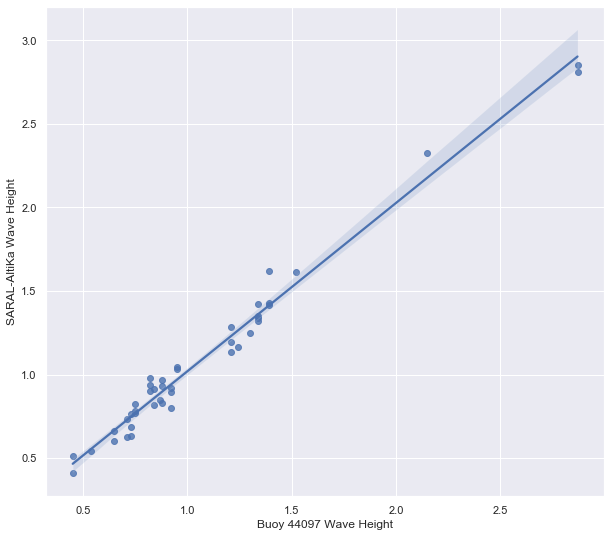

In [62]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='SARAL-AltiKa Wave Height', data=df1)

### Jason 3

In [34]:
a2 = [(swh_ja['lat'][m], swh_ja['lon'][m]) for m in range(swh_ja.shape[0])]

In [36]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav6 = haversine_vector([b44097]*swh_ja.shape[0],a2, Unit.KILOMETERS)

In [37]:
coloc_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
coloc_ja

,Buoy-Sat. Distance (km)
0,49.618908
1,45.180450
2,41.099112
3,37.491857
4,34.507550
...,...
9701,114.973633
9702,120.629514
9703,126.304099
9704,131.994902


In [38]:
dist_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
radius_ja = dist_ja['Buoy-Sat. Distance (km)'] < 10.
colocated_ja = swh_ja[radius_ja]
colocated_ja.reset_index(inplace=True)
colocated_ja.drop('index', 1, inplace=True)
colocated_ja

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh_ku,wind_speed_alt
0,2016-02-16 23:56:31.952804096,40.930508,288.963255,4.534,11.849999
1,2016-02-26 21:55:03.561579968,40.930680,288.960402,2.783,12.500000
2,2016-03-07 19:53:35.585849024,40.887271,288.921734,1.632,10.420000
3,2016-03-07 19:53:36.604559872,40.933202,288.955946,1.512,10.540000
4,2016-03-07 19:53:37.623270016,40.979121,288.990210,1.678,9.610000
...,...,...,...,...,...
264,2019-12-06 04:30:12.836276992,40.962249,288.987811,2.505,13.540000
265,2019-12-16 02:28:43.868327168,40.915402,288.952387,3.690,14.920000
266,2019-12-16 02:28:44.887036800,40.961320,288.986631,3.858,14.190000
267,2019-12-26 00:27:15.811104768,40.915600,288.950687,0.507,3.180000


In [39]:
sat_time_ja = colocated_ja['time'].reset_index()
sat_time_ja.drop('index', 1, inplace=True)

In [ ]:
#time difference in minutes
diff = [(b_time[d], b44097_wave['WVHT'][d], sat_time_ja['time'][s], colocated_ja['swh_ku'][s], (sat_time_ja['time'][s] - b_time[d]).total_seconds()
         / 60) for d, s in product(range(b_time.shape[0]), range(sat_time_ja.shape[0]))]

In [ ]:
t_ja = pd.DataFrame(list(diff))
t_ja.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'Jason 3 Time', 'Jason 3 Wave Height', 'Time Difference']
t_ja

In [ ]:
final_ja = abs(t_ja['Time Difference']) < 15.
final_ja = t_ja[final_ja]
final_ja

In [ ]:
df2 = final_ja.iloc[:,[1,3]]
df2.reset_index(inplace=True)
df2.drop('index', 1, inplace=True)
df2

In [ ]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='Jason 3 Wave Height', data=df2)

# References

1. SARAL-AltiKa products data handbook pp. 47
2. Jason 3 products data handbook pp. 36
3. CMEMS quality information document pp. 32